In [7]:
import pandas as pd
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import importlib


from load_and_sample import *
from guided_diffusion import guided_diffusion_1d
torch.set_float32_matmul_precision("high")

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using: {device}")

c:\Users\2023r\Documents\GuidedDiffusionProject\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using: cuda


In [2]:
# Read from the latent data file and put it into a dataloader

class LatentDataset(Dataset):
    def __init__(self, latents):
        self.latents = torch.from_numpy(latents).float().unsqueeze(1)

    def __len__(self):
        return len(self.latents)
    
    def __getitem__(self, idx):
        return self.latents[idx]


In [3]:
# Initialize the diffusion model

def create_diffusion_model(unet_dim=128, latent_dim=128, num_timesteps=1000):
    torch.cuda.empty_cache()

    unet_model = guided_diffusion_1d.Unet1D(
        dim = unet_dim,
        channels=1,
        dim_mults=(1, 2, 4, 8)
    ).to(device)

    diffusion_model = guided_diffusion_1d.GaussianDiffusion1D(
        unet_model,
        seq_length=latent_dim,
        timesteps=num_timesteps,
        objective='pred_v'
    ).to(device)

    return diffusion_model

def sample_diffusion(diffusion_model, sample_batch_size=4, latent_dim=128):
    diffusion_model.eval()
    with torch.no_grad():
        latents = diffusion_model.sample(batch_size=sample_batch_size)
        latents = latents.reshape(sample_batch_size, latent_dim)
        return latents
    

In [ ]:
# img display
from rdkit import Chem
from rdkit.Chem import Draw
import matplotlib.pyplot as plt
from matplotlib import image as mpimg
import io
def display_molecule(smiles_string, title=None):
    """
    Display molecular structure from SMILES string
    
    Args:
        smiles_string (str): SMILES notation of the molecule
        title (str): Optional title for the plot
    """
    try:
        # Parse SMILES string
        mol = Chem.MolFromSmiles(smiles_string)
        
        if mol is None:
            print(f"Error: Invalid SMILES string '{smiles_string}'")
            return
        
        # Generate 2D coordinates for better visualization
        from rdkit.Chem import rdDepictor
        rdDepictor.Compute2DCoords(mol)
        
        # Create molecular image
        img = Draw.MolToImage(mol, size=(400, 400))
        
        # Convert PIL image to numpy array for matplotlib
        img_array = mpimg.pil_to_array(img)
        
        # Display the image
        plt.figure(figsize=(8, 6))
        plt.imshow(img_array)
        plt.axis('off')
        
        if title:
            plt.title(title, fontsize=14, fontweight='bold')
        else:
            plt.title(f'Molecule: {smiles_string}', fontsize=12)
        
        plt.tight_layout()
        plt.show()
        
        # Print molecule information
        print(f"SMILES: {smiles_string}")
        # print(f"Molecular Formula: {Chem.rdMolDescriptors.CalcMolFormula(mol)}")
        # print(f"Molecular Weight: {Chem.rdMolDescriptors.CalcExactMolWt(mol):.2f}")
        # print(f"Number of Atoms: {mol.GetNumAtoms()}")
        # print(f"Number of Bonds: {mol.GetNumBonds()}")
        
    except ImportError as e:
        print("Error: Required packages not installed.")
        print("Install with: pip install rdkit matplotlib")
        print(f"Details: {e}")
    except Exception as e:
        print(f"Error processing molecule: {e}")


In [4]:
# parameters
latent_dim = 256
unet_dim = 256
train_batch_size = 16
sample_batch_size = 4
num_timesteps = 1000

In [ ]:
# Load the VAE
vae = load_vae_selfies("./saved_models/epoch=447-step=139328.ckpt")

# load the smiles data for verification
smiles_data = pd.read_csv("guacamol_v1_train.smiles", header=None)[0]

# load the selfies data (converted in data.ipynb)
selfies_data = pd.read_csv("output_selfies.csv")['SELFIES']



c:\Users\2023r\Documents\GuidedDiffusionProject\load_and_sample.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path_to_vae_statedict, map_locat

loading model from ./saved_models/epoch=447-step=139328.ckpt
Enc params: 1,994,592
Dec params: 277,346


Selfies: [C][C][=C][C][=C][Branch2][Ring1][C][C][=N][N][=C][Branch1][=Branch2][C][S][N][=N][C][=Ring1][Branch1][C][O][Ring1][O][S][Ring1][S]
Smiles: Cc1ccc(-c2nnc(-c3snnc3C)o2)s1


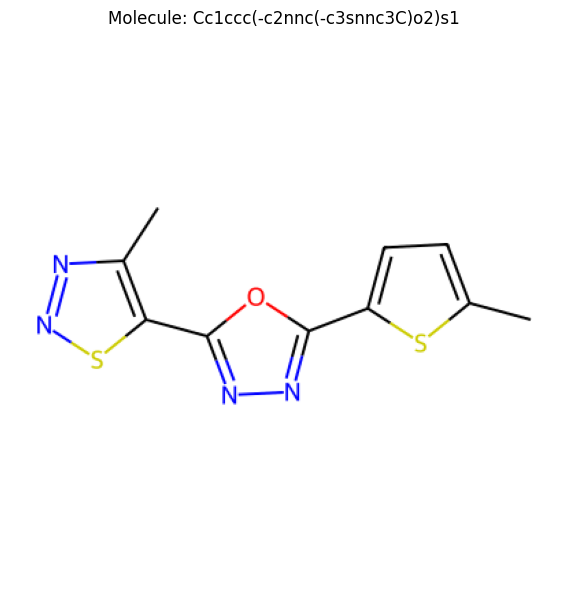

SMILES: Cc1ccc(-c2nnc(-c3snnc3C)o2)s1


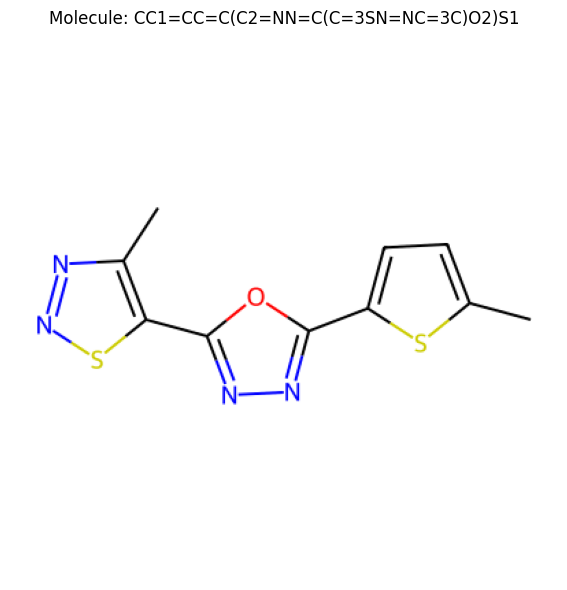

SMILES: CC1=CC=C(C2=NN=C(C=3SN=NC=3C)O2)S1
Cc1ccc(-c2nnc(-c3snnc3C)o2)s1
CC1=CC=C(C2=NN=C(C=3SN=NC=3C)O2)S1


In [36]:
# Test that it is working correctly:

selfies_x = selfies_data[200]
smiles_x = smiles_data[200]

print(f"Selfies: {selfies_x}")
print(f"Smiles: {smiles_x}")

decoded_smiles_x = sf.decoder(selfies_x)

display_molecule(smiles_x)
display_molecule(sf.decoder(selfies_x))

# Not the same, but since they display the same it seems legit to me
print(smiles_x)
print(decoded_smiles_x)


Shape = torch.Size([1, 128])


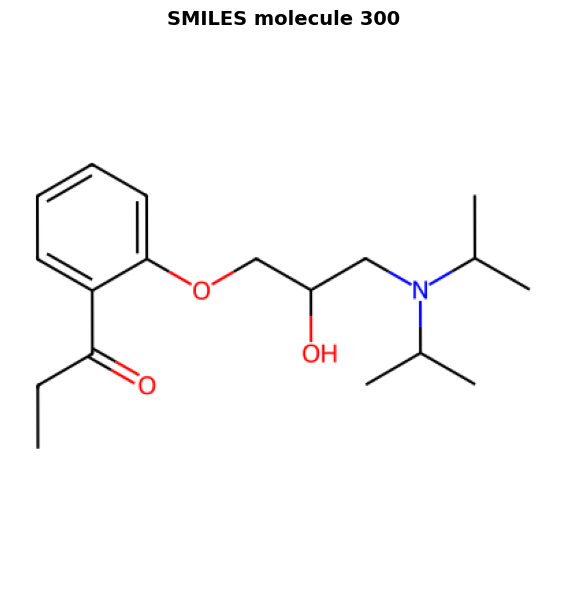

SMILES: CCC(=O)c1ccccc1OCC(O)CN(C(C)C)C(C)C


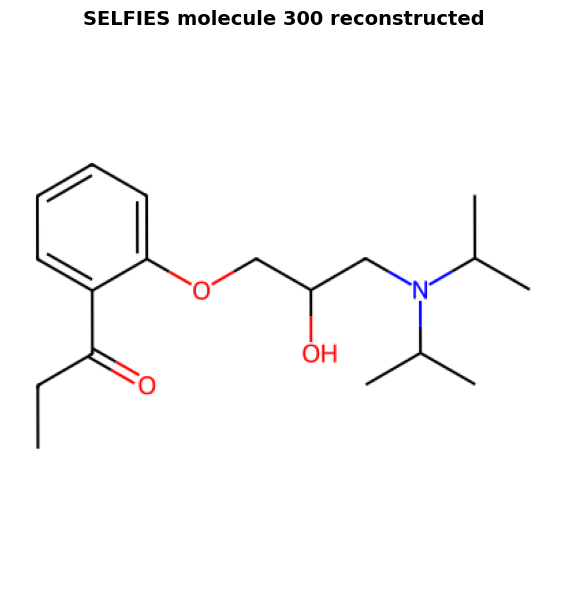

SMILES: CCC(=O)C1=CC=CC=C1OCC(O)CN(C(C)C)C(C)C


In [52]:
selfies_x = selfies_data[300]
selfies_z = selfies_to_latent(selfies_x, vae=vae)

print(f"Shape = {selfies_z.shape}")

selfies_x_reconstructed = latent_to_selfies(selfies_z, vae=vae)[0]

display_molecule(smiles_data[300], title="SMILES molecule 300")
display_molecule(sf.decoder(selfies_x_reconstructed), title="SELFIES molecule 300 reconstructed")


In [ ]:
selfies_df

0                [C][C][C][Branch1][C][C][Branch1][C][C][Br]
1          [C][C][C][N][Branch2][Ring1][Branch1][C][C][C]...
2          [O][C][=C][C][=C][Branch2][Ring1][#C][C][C][C]...
3          [C][C][Branch1][C][C][O][C][C][O][C][Branch1][...
4          [C][O][C][=Branch1][C][=O][C][=C][C][Branch2][...
                                 ...                        
1273074    [O][=C][Branch1][C][O][C][C][C][=C][C][=C][Bra...
1273075    [C][C][O][C][C][C][=C][C][=C][Branch2][Ring1][...
1273076    [N][C][C][C][C][=Branch1][C][=O][N][C][=C][C][...
1273077    [C][O][C][=C][C][=C][Branch2][Ring2][O][C][C][...
1273078    [O][=C][Branch2][Ring1][#Branch2][C][C][Branch...
Name: SELFIES, Length: 1273079, dtype: object

: 

In [ ]:
# make the data loader
dataloader = data_module.full_dataloader
for batch in dataloader:
    latent = batch['latent']
    print(f"latent shape: {latent.shape}")
    break

latent shape: torch.Size([16, 256])


In [15]:
def sample_diffusion(diffusion_model):
    diffusion_model.eval()
    with torch.no_grad():
        latents = diffusion_model.sample(batch_size=sample_batch_size)
        # latents are (b, 1, n), need to reshape
        latents = latents.reshape(sample_batch_size, latent_dim)
        return latents
    
def train_diffusion(diffusion_model, dataloader=dataloader, batch_size=train_batch_size, epochs=10, lr=1e-4, device=device):
    model = diffusion_model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0

        progress_bar = tqdm(enumerate(dataloader), total=len(dataloader), desc=f"Epoch {epoch}")

        for batch_idx, batch in progress_bar:
            latent = batch['latent']
            latent = latent.to(device)

            # IMPORTANT: the dataloader stores objects of shape (b, n), but the
            # UNET / diffusion want (b, 1, n)
            latent = latent.reshape(batch_size, 1, latent_dim)

            # When we sample, we will unshape this
            optimizer.zero_grad()
            loss = model(latent)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            if batch_idx % 100 == 0:
                print(f"Epoch {epoch}, Batch: {batch_idx}: Batch Loss: {loss.item()}")

        torch.save({'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, 'diff_checkpoints/best_model.pt')


        print(f"Epoch {epoch}, Average Loss: {epoch_loss / len(dataloader):.6f}")


In [ ]:
# Create diffusion model
importlib.reload(guided_diffusion.guided_diffusion_1d)
torch.cuda.empty_cache()

epochs = 1
print(f"Using device: {device}")


unet_model = guided_diffusion.guided_diffusion_1d.Unet1D(
    dim = unet_dim,
    channels=1,
    dim_mults=(1, 2, 4, 8)
).to(device)

diffusion_model = guided_diffusion.guided_diffusion_1d.GaussianDiffusion1D(
    unet_model,
    seq_length=latent_dim,
    timesteps=num_timesteps,
    objective='pred_v'
).to(device)


Using device: cuda


In [18]:
train_diffusion(diffusion_model, dataloader=dataloader, batch_size=train_batch_size, epochs=3)


Epoch 0:   0%|          | 3/642171 [00:01<80:38:52,  2.21it/s] 

Epoch 0, Batch: 0: Batch Loss: 0.5476900935173035


Epoch 0:   0%|          | 103/642171 [00:09<14:37:27, 12.20it/s]

Epoch 0, Batch: 100: Batch Loss: 0.1480012685060501


Epoch 0:   0%|          | 203/642171 [00:18<14:56:36, 11.93it/s]

Epoch 0, Batch: 200: Batch Loss: 0.22416701912879944


Epoch 0:   0%|          | 214/642171 [00:19<16:04:34, 11.09it/s]


KeyboardInterrupt: 